<a href="https://colab.research.google.com/github/itinasharma/DeepLearning/blob/main/MultiTaskLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

path = kagglehub.dataset_download("nih-chest-xrays/data")
print("Path to dataset files:", path)


100%|██████████| 42.0G/42.0G [08:05<00:00, 93.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


In [32]:
dataset_path = path

In [37]:
# ============================================================
# Multitask Learning on NIH ChestXray14 (TensorFlow 2.19)
# Uses ONLY `path` (cached kagglehub dataset folder)
# NO re-download here.
#
# Heads:
#   1) diseases: 14-label multi-label classification
#   2) abnormal: binary (any disease)
#
# Backbone:
#   EfficientNetB0 pretrained
#
# Includes:
#   - tf.data pipeline
#   - loss weighting
#   - abnormal sample weights
#   - warmup + finetune
# ============================================================

import os
import numpy as np
import pandas as pd
import tensorflow as tf

print("TensorFlow:", tf.__version__)
print("Using cached path:", path)

# -----------------------------
# 1) Load CSV
# -----------------------------
csv_path = os.path.join(path, "Data_Entry_2017.csv")
df = pd.read_csv(csv_path)
print("CSV rows:", len(df))

# -----------------------------
# 2) 14 disease labels
# -----------------------------
LABELS = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
    "Mass", "Nodule", "Pneumonia", "Pneumothorax",
    "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural_Thickening", "Hernia"
]

# -----------------------------
# 3) Index all images recursively
# -----------------------------
def index_all_images(root_dir):
    image_map = {}
    for root, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith(".png"):
                image_map[f] = os.path.join(root, f)
    return image_map

print("Indexing images (recursive)...")
image_map = index_all_images(path)
print("Total indexed images:", len(image_map))

# Keep only rows where image exists
df = df[df["Image Index"].isin(image_map.keys())].copy()
print("Rows with existing images:", len(df))

df["img_path"] = df["Image Index"].map(image_map)

# -----------------------------
# 4) Multi-hot labels
# -----------------------------
def make_multihot(label_str):
    vec = np.zeros(len(LABELS), dtype=np.float32)

    if isinstance(label_str, str):
        label_str = label_str.strip()
        if label_str == "No Finding":
            return vec

        for item in label_str.split("|"):
            item = item.strip()
            if item in LABELS:
                vec[LABELS.index(item)] = 1.0

    return vec

y_diseases = np.stack(df["Finding Labels"].apply(make_multihot).values)
y_abnormal = (y_diseases.sum(axis=1) > 0).astype(np.float32).reshape(-1, 1)

print("Label matrix shape:", y_diseases.shape, y_abnormal.shape)

# -----------------------------
# 5) Train/test split
# -----------------------------
from sklearn.model_selection import train_test_split

train_paths, test_paths, y_dis_train, y_dis_test, y_ab_train, y_ab_test = train_test_split(
    df["img_path"].values,
    y_diseases,
    y_abnormal,
    test_size=0.23,
    random_state=42,
    stratify=y_abnormal
)

print("Train:", train_paths.shape, y_dis_train.shape, y_ab_train.shape)
print("Test :", test_paths.shape, y_dis_test.shape, y_ab_test.shape)

# -----------------------------
# 6) Optional subset (debug fast)
# -----------------------------
SUBSET_TRAIN = 6000
SUBSET_TEST = 1500

train_paths = train_paths[:SUBSET_TRAIN]
y_dis_train = y_dis_train[:SUBSET_TRAIN]
y_ab_train = y_ab_train[:SUBSET_TRAIN]

test_paths = test_paths[:SUBSET_TEST]
y_dis_test = y_dis_test[:SUBSET_TEST]
y_ab_test = y_ab_test[:SUBSET_TEST]

print("Subset Train:", len(train_paths))
print("Subset Test :", len(test_paths))

# -----------------------------
# 7) Sample weights for abnormal
# -----------------------------
pos = float(y_ab_train.sum())
neg = float(len(y_ab_train) - pos)

pos_weight = neg / (pos + 1e-7)
ab_sample_weights = np.where(y_ab_train.reshape(-1) == 1.0, pos_weight, 1.0).astype(np.float32)

print(f"Abnormal positives: {int(pos)} / {len(y_ab_train)}")
print(f"pos_weight: {pos_weight:.2f}")

# -----------------------------
# 8) tf.data pipeline
# -----------------------------
IMG_SIZE = 224
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

def decode_png(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)
    return img

def preprocess(img_path, y_dis, y_ab, ab_w):
    img = decode_png(img_path)
    img = tf.keras.applications.efficientnet.preprocess_input(img)

    y = {
        "diseases": tf.cast(y_dis, tf.float32),
        "abnormal": tf.cast(y_ab, tf.float32),
    }

    ab_w = tf.cast(ab_w, tf.float32)
    ab_w = tf.reshape(ab_w, (1,))

    sw = {
        "diseases": tf.ones_like(y_ab, dtype=tf.float32),
        "abnormal": ab_w
    }

    return img, y, sw

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, y_dis_train, y_ab_train, ab_sample_weights))
train_ds = train_ds.shuffle(4096, seed=42, reshuffle_each_iteration=True)
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(
    (test_paths, y_dis_test, y_ab_test, np.ones(len(test_paths), dtype=np.float32))
)
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("✅ tf.data ready")

# -----------------------------
# 9) Model: EfficientNetB0 multitask
# IMPORTANT: output layers MUST be named
# -----------------------------
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

backbone = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs
)
backbone.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(backbone.output)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Head 1: diseases (named)
h1 = tf.keras.layers.Dense(128, activation="relu")(x)
diseases_out = tf.keras.layers.Dense(14, activation="sigmoid", name="diseases")(h1)

# Head 2: abnormal (named)
h2 = tf.keras.layers.Dense(64, activation="relu")(x)
abnormal_out = tf.keras.layers.Dense(1, activation="sigmoid", name="abnormal")(h2)

model = tf.keras.Model(
    inputs=inputs,
    outputs={
        "diseases": diseases_out,
        "abnormal": abnormal_out
    }
)

# -----------------------------
# 10) Compile
# -----------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        "diseases": tf.keras.losses.BinaryCrossentropy(),
        "abnormal": tf.keras.losses.BinaryCrossentropy(),
    },
    loss_weights={
        "diseases": 1.0,
        "abnormal": 2.0,
    },
    metrics={
        "diseases": [tf.keras.metrics.AUC(curve="ROC", multi_label=True, name="auc")],
        "abnormal": [tf.keras.metrics.AUC(curve="ROC", name="auc")],
    }
)

model.summary()

# -----------------------------
# 11) Callbacks
# -----------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, verbose=1),
]

# -----------------------------
# 12) Warmup training
# -----------------------------
history1 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    callbacks=callbacks
)

# -----------------------------
# 13) Fine-tune
# -----------------------------
backbone.trainable = True

for layer in backbone.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        "diseases": tf.keras.losses.BinaryCrossentropy(),
        "abnormal": tf.keras.losses.BinaryCrossentropy(),
    },
    loss_weights={
        "diseases": 1.0,
        "abnormal": 2.0,
    },
    metrics={
        "diseases": [tf.keras.metrics.AUC(curve="ROC", multi_label=True, name="auc")],
        "abnormal": [tf.keras.metrics.AUC(curve="ROC", name="auc")],
    }
)

history2 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    callbacks=callbacks
)

print("✅ Training complete")


TensorFlow: 2.19.0
Using cached path: /root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3
CSV rows: 112120
Indexing images (recursive)...
Total indexed images: 112120
Rows with existing images: 112120
Label matrix shape: (112120, 14) (112120, 1)
Train: (86332,) (86332, 14) (86332, 1)
Test : (25788,) (25788, 14) (25788, 1)
Subset Train: 6000
Subset Test : 1500
Abnormal positives: 2792 / 6000
pos_weight: 1.15
✅ tf.data ready


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_4     │ (None, 224, 224,  │          7 │ rescaling_8[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_9         │ (None, 224, 224,  │          0 │ normalization_4[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_9[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,428,722 (16.89 MB)

 Trainable params: 379,151 (1.45 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 711s 7s/step - abnormal_auc: 0.6217 - abnormal_loss: 0.7296 - diseases_auc: 0.5138 - diseases_loss: 0.2731 - loss: 1.7322 - val_abnormal_auc: 0.6914 - val_abnormal_loss: 0.6648 - val_diseases_auc: 0.6104 - val_diseases_loss: 0.1772 - val_loss: 1.5052 - learning_rate: 0.0010
Epoch 2/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 719s 7s/step - abnormal_auc: 0.6693 - abnormal_loss: 0.6972 - diseases_auc: 0.5828 - diseases_loss: 0.1800 - loss: 1.5743 - val_abnormal_auc: 0.6873 - val_abnormal_loss: 0.6624 - val_diseases_auc: 0.6578 - val_diseases_loss: 0.1771 - val_loss: 1.4997 - learning_rate: 0.0010
Epoch 3/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 681s 7s/step - abnormal_auc: 0.6846 - abnormal_loss: 0.6878 - diseases_auc: 0.6156 - diseases_loss: 0.1812 - loss: 1.5568 - val_abnormal_auc: 0.6975 - val_abnormal_loss: 0.6413 - val_diseases_auc: 0.6682 - val_diseases_loss: 0.1723 - val_loss: 1.4528 - learning_rate: 0.0010
Epoch 1/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 795s 8s/step - abnormal_auc

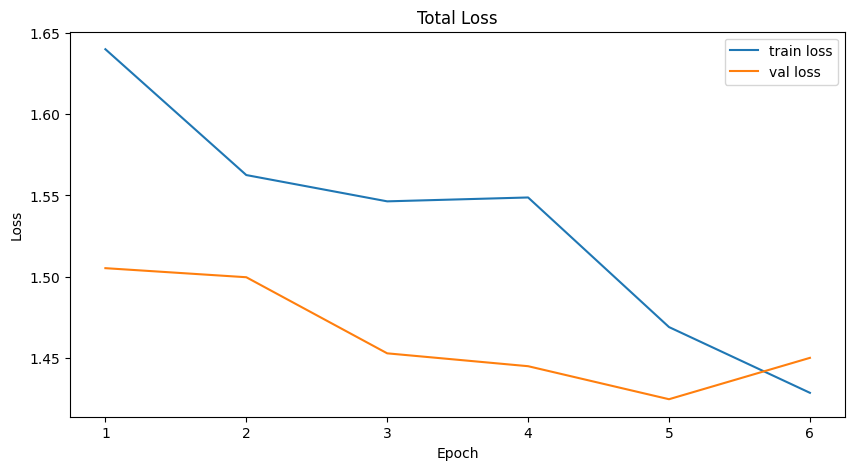

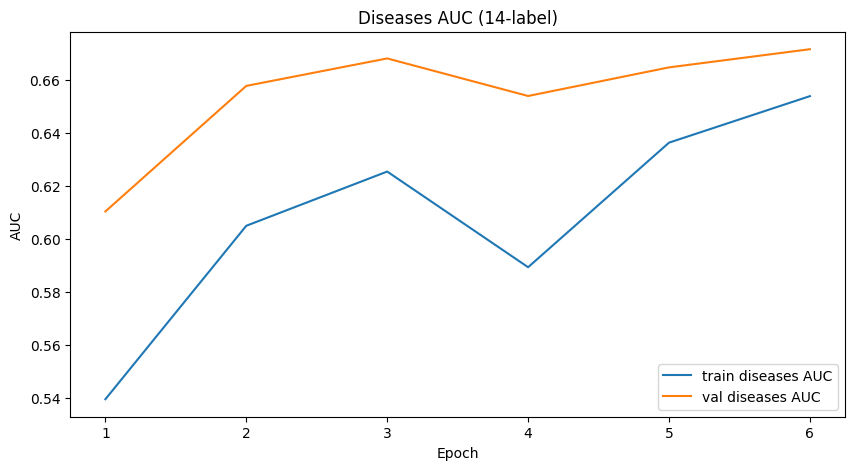

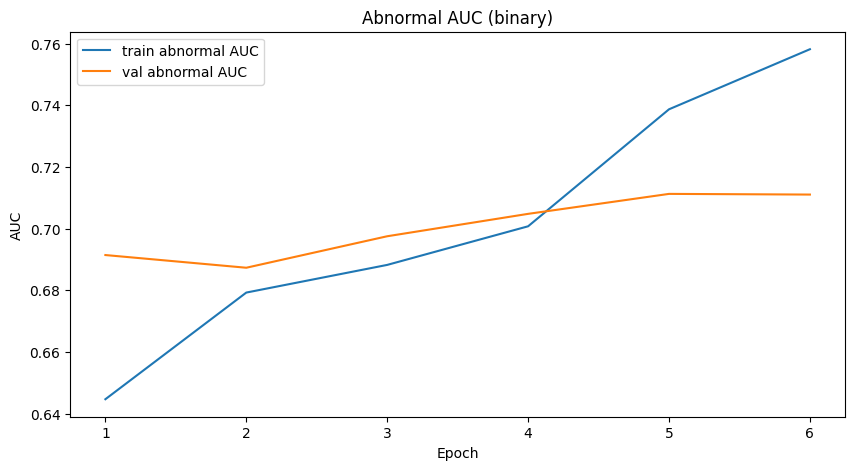

In [38]:
import matplotlib.pyplot as plt

def merge_histories(h1, h2):
    merged = {}
    for k in h1.history.keys():
        merged[k] = h1.history[k] + h2.history.get(k, [])
    return merged

hist = merge_histories(history1, history2)

epochs = range(1, len(hist["loss"]) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, hist["loss"], label="train loss")
plt.plot(epochs, hist["val_loss"], label="val loss")
plt.title("Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, hist["diseases_auc"], label="train diseases AUC")
plt.plot(epochs, hist["val_diseases_auc"], label="val diseases AUC")
plt.title("Diseases AUC (14-label)")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, hist["abnormal_auc"], label="train abnormal AUC")
plt.plot(epochs, hist["val_abnormal_auc"], label="val abnormal AUC")
plt.title("Abnormal AUC (binary)")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.show()
